# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Установка отображения не более двух знаков после запятой

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

Импортируем игнорирование предупреждений

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
print(data_1.shape)
data_1.head()

(100000, 5)


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [5]:
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
print(data_2.shape)
data_2.head()

(100000, 5)


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [6]:
data_3 = pd.read_csv('/datasets/geo_data_2.csv')
print(data_3.shape)
data_3.head()

(100000, 5)


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Функция для ознакомления с данными

In [7]:
def first_glance(data):
    data.info()
    print()
    print(data[data.columns[0]].value_counts())
    print()
    print(data.describe())
    print()
    print(data.corr())
    sns.boxplot(y=data['product'])
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

74z30    2
A5aEY    2
QcMuo    2
Tdehs    2
bsk9y    2
        ..
bdy9X    1
Onsqg    1
t35fo    1
hL8qG    1
HeLjD    1
Name: id, Length: 99990, dtype: int64

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        0.50       0.25       2.50      92.50
std         0.87       0.50       3.25      44.29
min        -1.41      -0.85     -12.09       0.00
25%        -0.07      -0.20       0.29      56.50
50%         0.50       0.25       2.52      91.85
75%         1.07       0.70       4.72     128.56
max         2.36       1.34      16.00     185.36

           f0    f1    f2  product
f0       1.00 -0.4

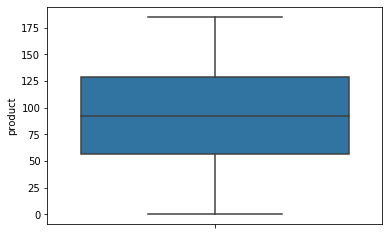

In [8]:
first_glance(data_1)

In [9]:
data_1[data_1['id'] == 'QcMuo']

,id,f0,f1,f2,product
1949,QcMuo,0.51,-0.32,-2.22,75.50
63593,QcMuo,0.64,-0.47,0.86,64.58


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

5ltQ6    2
wt4Uk    2
LHZR0    2
bfPNe    2
BEh6E    1
        ..
v4sNV    1
VENQZ    1
YQfzc    1
SFnat    1
yklJh    1
Name: id, Length: 99996, dtype: int64

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        1.14      -4.80       2.49      68.83
std         8.97       5.12       1.70      45.94
min       -31.61     -26.36      -0.02       0.00
25%        -6.30      -8.27       1.00      26.95
50%         1.15      -4.81       2.01      57.09
75%         8.62      -1.33       4.00     107.81
max        29.42      18.73       5.02     137.95

           f0    f1    f2  product
f0       1.00  0.1

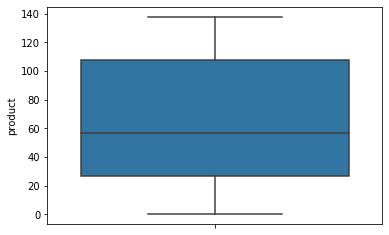

In [10]:
first_glance(data_2)

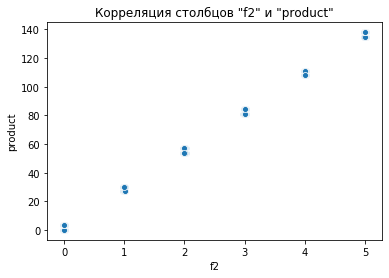

In [11]:
scatter = sns.scatterplot(data_2['f2'], data_2['product'])
scatter.axes.set_title('Корреляция столбцов "f2" и "product"')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

xCHr8    2
Vcm5J    2
VF7Jo    2
KUPhW    2
RSoEN    1
        ..
0TNKv    1
oLncY    1
COfBs    1
2VJ0O    1
bV5MR    1
Name: id, Length: 99996, dtype: int64

              f0         f1         f2    product
count 100,000.00 100,000.00 100,000.00 100,000.00
mean        0.00      -0.00       2.50      95.00
std         1.73       1.73       3.47      44.75
min        -8.76      -7.08     -11.97       0.00
25%        -1.16      -1.17       0.13      59.45
50%         0.01      -0.01       2.48      94.93
75%         1.16       1.16       4.86     130.60
max         7.24       7.84      16.74     190.03

           f0    f1    f2  product
f0       1.00  0.0

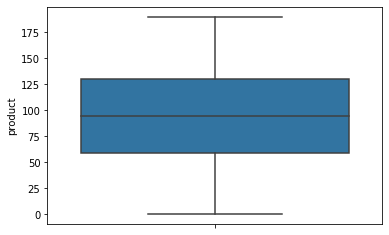

In [12]:
first_glance(data_3)

### Вывод

1. Пропущенные значения отсутствуют
2. Сильной взаимосвязи, которая могла негативно повлять на работу модели, между признаками не выявлено
3. Однако, существует положительная прямая корреляция между столбцами f2 и product

## Обучение и проверка модели

Функция, выполняющая предсказания:
1. на вход получает таблицу с данными и номер региона
2. разбивает на обучающую и валидационную выборки
3. с помощью модели Линейной регрессии выполняет предсказания объема запасов сырья в скважинах
4. выполняет масштабирование признаков
5. печатает средний объем запасов сырья в скважинах по региону, а также rmse модели
6. возвращает массив предсказаний, целевые значения валидационной выборки и средний объем запасов сырья в скважинах по региону

In [13]:
scaler = StandardScaler()

In [14]:
def predictions(data, number):
#     if number == 2:
#         features = data.drop(['product', 'id','f2'], axis=1)
#         target = data['product']
#     else:
#         features = data.drop(['product', 'id'], axis=1)
#         target = data['product']
        
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
    )
    
    print(f'Обучающая выборка: ',features_train.shape, target_train.shape)
    print(f'Валидационная выборка: ', features_valid.shape, target_valid.shape)
    print()
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    product_mean = predictions_valid.mean()
    rmse = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    
    print(f'Средний запас предсказанного сырья (Регион {number}): {product_mean}')
    print(f'RMSE модели: {rmse}')
    print()
    
    scaler.fit(features_train)
    features_target_scaled = scaler.transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)
    
    model = LinearRegression()
    model.fit(features_target_scaled, target_train)
    predictions_valid_scaled = model.predict(features_valid_scaled)
    product_mean_scaled = predictions_valid_scaled.mean()
    rmse_scaled = np.sqrt(mean_squared_error(target_valid, predictions_valid_scaled))

    print(f'Средний запас предсказанного сырья (масштабированные признаки): {product_mean_scaled}')
    print(f'RMSE модели (масштабированные признаки): {rmse_scaled}')
    
    return predictions_valid, target_valid, product_mean

In [15]:
predictions_valid_1, target_valid_1, product_mean_1 = predictions(data_1, 1)

Обучающая выборка:  (75000, 3) (75000,)
Валидационная выборка:  (25000, 3) (25000,)

Средний запас предсказанного сырья (Регион 1): 92.59256778438038
RMSE модели: 37.5794217150813

Средний запас предсказанного сырья (масштабированные признаки): 92.59256778438038
RMSE модели (масштабированные признаки): 37.5794217150813


In [16]:
predictions_valid_2, target_valid_2, product_mean_2 = predictions(data_2, 2)

Обучающая выборка:  (75000, 3) (75000,)
Валидационная выборка:  (25000, 3) (25000,)

Средний запас предсказанного сырья (Регион 2): 68.728546895446
RMSE модели: 0.893099286775616

Средний запас предсказанного сырья (масштабированные признаки): 68.728546895446
RMSE модели (масштабированные признаки): 0.8930992867756158


In [17]:
predictions_valid_3, target_valid_3, product_mean_3 = predictions(data_3, 3)

Обучающая выборка:  (75000, 3) (75000,)
Валидационная выборка:  (25000, 3) (25000,)

Средний запас предсказанного сырья (Регион 3): 94.96504596800489
RMSE модели: 40.02970873393434

Средний запас предсказанного сырья (масштабированные признаки): 94.96504596800489
RMSE модели (масштабированные признаки): 40.02970873393434


Функция по преверки модели на адекватность:
1. на вход получает таблицу с данными и номер региона
2. разбивает на обучающую и валидационную выборки
3. выполняет предсказания объема запасов сырья в скважинах случаным образом
4. печатает средний объем запасов сырья в скважинах по региону, средний запас сырья по целевой выборке, а также rmse модели
5. возвращает средний объем запасов сырья в скважинах по региону и средний запас сырья по целевой выборке

In [18]:
def check_relevance(data, number):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
    )
    
    model = DummyRegressor()#strategy='mean')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    product_mean_dummy = predictions_valid.mean()
    product_mean_target = target_valid.mean()
    rmse = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    
    print(f'Средний запас случайно предсказанного сырья (Регион {number}): {product_mean_dummy}')
    print(f'Средний запас (целевой): {product_mean_target}')
    print(f'RMSE случайной модели: {rmse}')
    
    return product_mean_dummy, product_mean_target

In [19]:
product_mean_dummy_1, product_mean_target_1 = check_relevance(data_1, 1)

Средний запас случайно предсказанного сырья (Регион 1): 92.64046775305694
Средний запас (целевой): 92.07859674082927
RMSE случайной модели: 44.289591053907365


In [20]:
product_mean_dummy_2, product_mean_target_2 = check_relevance(data_2, 2)

Средний запас случайно предсказанного сырья (Регион 2): 68.85895465854665
Средний запас (целевой): 68.72313602435997
RMSE случайной модели: 46.02144533725462


In [21]:
product_mean_dummy_3, product_mean_target_3 = check_relevance(data_3, 3)

Средний запас случайно предсказанного сырья (Регион 3): 95.03858906371526
Средний запас (целевой): 94.88423280885438
RMSE случайной модели: 44.90234968510566


In [22]:
ratio = pd.DataFrame([
    ['Целевой', product_mean_target_1, product_mean_target_2, product_mean_target_3],
    ['Предсказанный', product_mean_1, product_mean_2, product_mean_3],
    ['Случайный', product_mean_dummy_1, product_mean_dummy_2, product_mean_dummy_3]
],columns=['Средний запас сырья', 'Регион_1', 'Регион_2', 'Регион_3']
)
ratio

,Средний запас сырья,Регион_1,Регион_2,Регион_3
0,Целевой,92.08,68.72,94.88
1,Предсказанный,92.59,68.73,94.97
2,Случайный,92.64,68.86,95.04


### Вывод

1. По среднему объему сырья в скважинах, предсказанному моделью, лидируют регионы 1 и 3. В регионе 2 средние запасы значительно меньше
2. Масштабирование признаков с помощью стандартизации данных не улучшило алгоритм модели
3. Модель Линейной Регрессии точнее предсказала средний объем сырья, чем случайная модель, хотя разница очень незначительная

## Подготовка к расчёту прибыли

Сохраняем постоянные значения в переменных:
- расходы (бюджет на разработку), тыс. рублей;
- доход от баррелей, тыс. рублей;
- всего мест для исследования, шт.;
- кол-во выбранных (лучших) мест для разведки, шт. 

In [23]:
expenses = 10000000
revenue_barrels = 450
all_places = 500
amount_places = 200

In [24]:
min_amount_barrels = np.round(expenses / revenue_barrels)
print('Объём сырья для безубыточной разработки новой скважины: не менее {:,.0f} тыс. баррелей'.format(
    min_amount_barrels).replace(",", "'")
     )

Объём сырья для безубыточной разработки новой скважины: не менее 22'222 тыс. баррелей


In [25]:
barrels_1 = np.round(product_mean_1 * amount_places)
print('Средний запас сырья в Регионе 1 (для 200 скважин): {:,.0f} тыс. баррелей'.format(
    barrels_1).replace(",", "'")
     )

Средний запас сырья в Регионе 1 (для 200 скважин): 18'519 тыс. баррелей


In [26]:
barrels_2 = np.round(product_mean_2 * amount_places)
print('Средний запас сырья в Регионе 1 (для 200 скважин): {:,.0f} тыс. баррелей'.format(
    barrels_2).replace(",", "'")
     )

Средний запас сырья в Регионе 1 (для 200 скважин): 13'746 тыс. баррелей


In [27]:
barrels_3 = np.round(product_mean_3 * amount_places)
print('Средний запас сырья в Регионе 1 (для 200 скважин): {:,.0f} тыс. баррелей'.format(
    barrels_3).replace(",", "'")
     )

Средний запас сырья в Регионе 1 (для 200 скважин): 18'993 тыс. баррелей


In [28]:
pd.DataFrame([
    ['Регион 1', barrels_1, min_amount_barrels],
    ['Регион 2', barrels_2, min_amount_barrels],
    ['Регион 3', barrels_3, min_amount_barrels]],
    columns=['Регион', 'Средний запас сырья, тыс. барр.', 'Безубыточной запас сырья, тыс. барр.']
)

,Регион,"Средний запас сырья, тыс. барр.","Безубыточной запас сырья, тыс. барр."
0,Регион 1,"18,519.00","22,222.00"
1,Регион 2,"13,746.00","22,222.00"
2,Регион 3,"18,993.00","22,222.00"


### Вывод:
1. для безубыточной разработки новой скважины в регионе требуется не менее 22 222 тыс. баррелей
2. среднего запаса сырья по региону не достаточно для безубыточной разработки
3. в Регионе 2 наименьший средний запас сырья

## Расчёт прибыли для регионов

Функция по расчету прибыли в топ-200 сважин с наибольшим запасом сырья:
1. принимает предсказания, целевые значения, номер региона
2. сортирует предсказания по убыванию (предсказания)
3. суммирует запасы сырья из топ-200 сважин (целевая выборка)
4. рассчитывает ожидаемую прибыль

In [29]:
def count_profit(predictions, target, region):
    predictions_sorted = (pd.Series(predictions).sort_values(ascending=False))
    
    target = target.reset_index(drop=True)
    barrels = (target[predictions_sorted.index][:amount_places]).sum()
    profit_expected = barrels * revenue_barrels - expenses
    
    print('Ожидаемая прибыль (убыток) в Регионе {}: {:,.0f} тыс. руб.'.format(region, profit_expected).replace(",", "'"))
    return profit_expected.round()

In [30]:
profit_expected_1 = count_profit(predictions_valid_1, target_valid_1, 1)

Ожидаемая прибыль (убыток) в Регионе 1: 3'320'826 тыс. руб.


In [31]:
profit_expected_2 = count_profit(predictions_valid_2, target_valid_2, 2)

Ожидаемая прибыль (убыток) в Регионе 2: 2'415'087 тыс. руб.


In [32]:
profit_expected_3 = count_profit(predictions_valid_3, target_valid_3, 3)

Ожидаемая прибыль (убыток) в Регионе 3: 2'710'350 тыс. руб.


In [33]:
table = pd.DataFrame([
    ['Регион 1', profit_expected_1],
    
    ['Регион 2', profit_expected_2],
    
    ['Регион 3', profit_expected_3],

], 
    columns=['Регион', 'Ожидаемая прибыль (убыток) (тыс. руб)']
    )
table

,Регион,Ожидаемая прибыль (убыток) (тыс. руб)
0,Регион 1,"3,320,826.00"
1,Регион 2,"2,415,087.00"
2,Регион 3,"2,710,350.00"


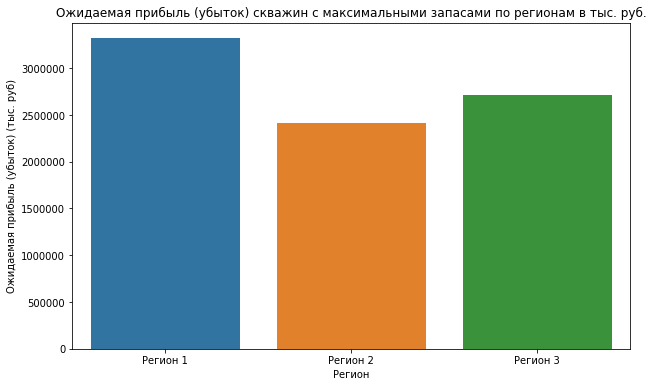

In [34]:
plt.figure(figsize=(10,6))
barplot_1 = sns.barplot(x=table.iloc[:,0],y=table.iloc[:,1])
barplot_1.axes.set_title('Ожидаемая прибыль (убыток) скважин с максимальными запасами по регионам в тыс. руб.')

plt.show()

### Вывод:   
максимальная прибыль из топ-200 скважин ожидается в Регионе 1 со значительным отрывом, минимальная - в Регионе 2
 

## Расчет рисков и прибыли для регионов

In [35]:
state = np.random.RandomState(12345)

Функция по определению рисков для регионов:
1. принимает целевые значения, предсказания, номер региона
2. циклом формирует 1000 случайных подвыборок - target_subsample (количество скважин равным 500 штук) из целевой выборки (target_valid)
3. формирует подвыборку - prediction_subsample, соответствующую значениям целевой подвыборки, из массива предсказаний (predictions_valid)
4. сортирует prediction_subsample по убыванию
5. суммирует запасы сырья из топ-200 сважин (target_subsample)
6. вычисляет и печатает: 2.5% и 97.5% перцентили, среднюю прибыль в регионе, вероятность убытка
7. возвращает среднюю прибыль и 2.5%-перцентиль

In [36]:
def bootstrap(target, predictions, region):
    values=[]
    loss_count=0
    for i in range(1000):
        target = target.reset_index(drop=True)
        target_subsample = target.sample(
            n = all_places,
            replace = True,
            random_state = state
        )
        
        predictions = pd.Series(predictions)
        prediction_subsample = predictions[target_subsample.index]
        
#         values.append(count_profit(prediction_subsample,target_subsample))
        
        prediction_sorted = prediction_subsample.sort_values(ascending=False)
        barrels = target_subsample[prediction_sorted.index][:amount_places].sum()
        profit_expected = barrels * revenue_barrels - expenses
        if profit_expected < 0:
            loss_count += 1
        values.append(profit_expected)
#         print('{:,.2f}'.format(profit_expected))
    sns.boxplot(y=values)
    plt.show()
        
    values = pd.Series(values)
    lower_profit = values.quantile(q=0.025)
    upper_profit = values.quantile(q=0.975)
    mean_profit = values.mean()
    prob_loss = loss_count / len(values)
    
    print('Средняя прибыль (убыток) в Регионе {} составила: {:,.0f} тыс. руб.'.format(region, mean_profit))
    print('2.5%-квантиль: {:,.0f} тыс. руб.'.format(lower_profit))
    print('97.5%-квантиль: {:,.0f} тыс. руб.'.format(upper_profit))
    print('Вероятность убытка для Региона {}: {:.1%}'.format(region, prob_loss))
    
    return mean_profit.round(), np.round(lower_profit, decimals=0)

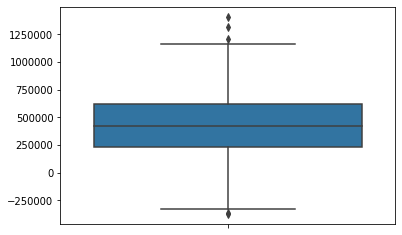

Средняя прибыль (убыток) в Регионе 1 составила: 425,939 тыс. руб.
2.5%-квантиль: -102,090 тыс. руб.
97.5%-квантиль: 947,976 тыс. руб.
Вероятность убытка для Региона 1: 6.0%


In [37]:
mean_profit_1, lower_profit_1 = bootstrap(target_valid_1, predictions_valid_1, 1)

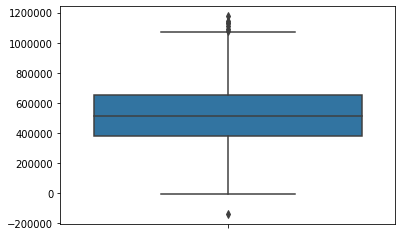

Средняя прибыль (убыток) в Регионе 2 составила: 518,259 тыс. руб.
2.5%-квантиль: 128,123 тыс. руб.
97.5%-квантиль: 953,613 тыс. руб.
Вероятность убытка для Региона 2: 0.3%


In [38]:
mean_profit_2, lower_profit_2 = bootstrap(target_valid_2, predictions_valid_2, 2)

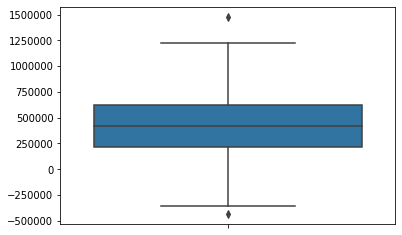

Средняя прибыль (убыток) в Регионе 3 составила: 420,194 тыс. руб.
2.5%-квантиль: -115,853 тыс. руб.
97.5%-квантиль: 989,630 тыс. руб.
Вероятность убытка для Региона 3: 6.2%


In [39]:
mean_profit_3, lower_profit_3 = bootstrap(target_valid_3, predictions_valid_3, 3)

In [40]:
results = pd.DataFrame([
    ['Регион 1', mean_profit_1, lower_profit_1],
    
    ['Регион 2', mean_profit_2, lower_profit_2],
    
    ['Регион 3', mean_profit_3, lower_profit_3],

], 
    columns=['Регион', 'Средняя прибыль (убыток) (тыс. руб.)', '2.5%-квантиль (тыс. руб.)']
    )
results

,Регион,Средняя прибыль (убыток) (тыс. руб.),2.5%-квантиль (тыс. руб.)
0,Регион 1,"425,939.00","-102,090.00"
1,Регион 2,"518,259.00","128,123.00"
2,Регион 3,"420,194.00","-115,853.00"


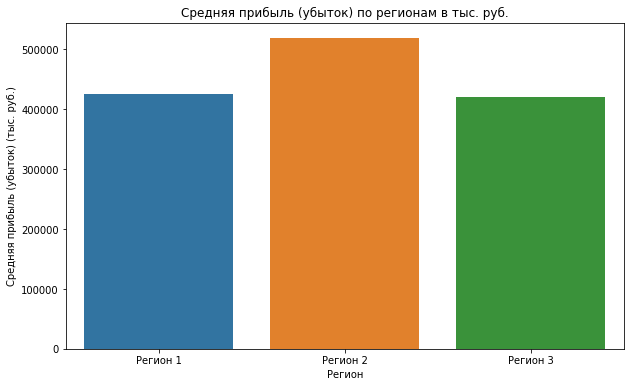

In [41]:
plt.figure(figsize=(10,6))
barplot_2 = sns.barplot(x=results.iloc[:,0],y=results.iloc[:,1])
barplot_2.axes.set_title('Средняя прибыль (убыток) по регионам в тыс. руб.')

plt.show()

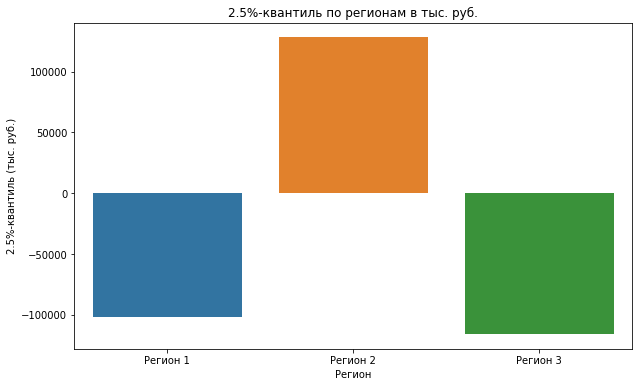

In [42]:
plt.figure(figsize=(10,6))
barplot_3 = sns.barplot(x=results.iloc[:,0],y=results.iloc[:,2])
barplot_3.axes.set_title('2.5%-квантиль по регионам в тыс. руб.')

plt.show()

### Вывод:
1. при случайном формировании подвыборок с 500 скважинами, и выбирая из которых 200 скважин с наибольшими запасами сырья, наибольшую прибыль показывает Регион 2
2. к тому же, только в Регионе 2 в 97.5% разведка принесет прибыль, а не убыток
3. графики boxplot показывают, что для Региона 2 значения прибыли ниже нуля являются выбросами, то есть крайне редки. В регионах 1 и 3 значения прибыли ниже нуля входят в 1.5 межквартильных размаха, то есть частые значения

## Общий вывод:
1. получили таблицы с данными по трем регионам (уникальное значение скважины, признаки для обучения модели, запас сырья в скважине) с целью определить регион, где добыча принесёт наибольшую прибыль
2. пропущенных значений и сильной корреляции признаков, негативно сказывающихся на обучении модели, не выявлено
3. выявлено, что среднего запаса сырья в скважинах каждого региона не достаточно для преодоления безубыточности. При этом показатели Регионов 1 и 3 значительно выше показателей Региона 2
4. при предварительном расчете прибыли в регионе по скважинам с максимальными запасами сырья лидирует Регион 1
5. однако, формируя случайные выборки по скважинам 1000 раз, получение максимальной прибыли и безубыточности в 97.5% случаев гарантирует только Регион 2, вероятно, вызвано наличием в Регионах 1 и 3 малого количества скважин с большим количеством запасов сырья.   
    На основании вышеизложенного, с целью получения максимальной прибыли и минимальной вероятности убытка для разведки предлагается Регион № 2.